In [ ]:
!pip install prophet




Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 65 kB 3.0 MB/s 
     |████████████████████████████████| 49 kB 5.1 MB/s 
     |████████████████████████████████| 45 kB 3.0 MB/s 
  Created wheel for prophet: filename=prophet-1.0.1-py3-none-any.whl size=6641359 sha256=2fb6b6a5701c4a666ba17f930a1d6720e5b6f5d73530201ad0ccd386d449c7a0
  Stored in directory: /root/.cache/pip/wheels/4e/a0/1a/02c9ec9e3e9de6bdbb3d769d11992a6926889d71567d6b9b67
Successfully built prophet
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 0.9.5
    Uninstalling cmdstanpy-0.9.5:
      Successfully uninstalled cmdstanpy-0.9.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fbprophet 0.7.1 requires cmdstanpy==0.9.5, but you have cmdstanpy 0.9.68 which is incompatible.
Mounted at

In [ ]:

from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
from prophet import Prophet

import requests

!rm -r /content/GreenSaturdaysAI
!git clone https://github.com/AGMAndirko/GreenSaturdaysAI/

import sys
sys.path.append('/content/GreenSaturdaysAI/src/')
import utils

#Llamada al df

root = "/content/GreenSaturdaysAI/datasets/"
df = utils.mediciones_unif(root+'medidas/', root+'/estaciones/2021/', root+'/meta/')
df = utils.add_festivos_findes(df)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
rm: cannot remove '/content/GreenSaturdaysAI': No such file or directory
Cloning into 'GreenSaturdaysAI'...
remote: Enumerating objects: 510, done.
remote: Counting objects: 100% (153/153), done.
remote: Compressing objects: 100% (107/107), done.
remote: Total 510 (delta 68), reused 115 (delta 42), pack-reused 357
Receiving objects: 100% (510/510), 37.40 MiB | 17.31 MiB/s, done.
Resolving deltas: 100% (270/270), done.
Checking out files: 100% (70/70), done.


/content/GreenSaturdaysAI/src/utils.py:100: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  inicio = pd.datetime.strptime('01/01/2020', '%d/%m/%Y')
/content/GreenSaturdaysAI/src/utils.py:101: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  fin = pd.datetime.strptime('31/12/2021', '%d/%m/%Y')


In [ ]:
# tira columnas innecesarias
df_no_extra_cols = df.drop(['Estacio', 'ubicacio', 'nom_cabina', 'codi_dtes', 'Longitud', 'Latitud', 'Nom_barri', 'Clas_2', 'Codi_Contaminant_x',	'Codi_Contaminant_y', 'V01', 'V02',  'V03', 'V04','V05','V06','V07', 'V08',\
                             'V09', 'V10', 'V11', 'V12','V13', 'V14','V15', 'V16', 'V17', 'V18', 'V19', 'V20',  'V21', 'V22', 'V23', 'V24' ], axis = 1)
# hace media contaminantes por dia
df_no_extra_cols['average_contaminante'] = df_no_extra_cols[[ 'H01', 'H02',  'H03', 'H04','H05','H06','H07', 'H09', 'H10', 'H11', 'H12','H13', 'H14','H15', 'H16', 'H17', 'H18', 'H19', 'H20',  'H21', 'H22', 'H23', 'H24']].mean(axis=1)
# tira las horas
df_no_extra_cols_avg = df_no_extra_cols.drop(['H01', 'H02',  'H03', 'H04','H05','H06','H07', 'H08', 'H09', 'H10', 'H11', 'H12','H13', 'H14','H15', 'H16', 'H17', 'H18', 'H19', 'H20',  'H21', 'H22', 'H23', 'H24'], axis = 1)
#quita duplicados
df_pre_final = df_no_extra_cols_avg.drop_duplicates()
print(df_pre_final)



        ESTACIO Desc_Contaminant       fecha  confinamiento  festivo  findes  \
0             4               NO  2020-01-01              0        1       0   
4             4               NO  2020-01-02              0        0       0   
8             4               NO  2020-01-03              0        0       0   
12            4               NO  2020-01-04              1        0       1   
16            4               NO  2020-01-05              1        0       1   
...         ...              ...         ...            ...      ...     ...   
282718       58               O3  2021-12-26              0        0       1   
282719       58               O3  2021-12-27              0        0       0   
282720       58               O3  2021-12-28              0        0       0   
282721       58               O3  2021-12-29              0        0       0   
282722       58               O3  2021-12-30              0        0       0   

        average_contaminante  
0       

In [ ]:
# Modelling holidays
#default es 0 (no reseñable)
df_pre_final['lower_window'] = 0 
df_pre_final['upper_window'] = 0 
# en findes y festivos espero más contaminantes, en confinamiento menos
#df_pre_final.loc[df_pre_final['findes'] == 1,'upper_window'] = 1
df_pre_final.loc[df_pre_final['festivo'] == 1,'upper_window'] = 1
#df_pre_final.loc[df_pre_final['confinamiento'] == 1,'lower_window'] = 1
#df_pre_final.loc[df_pre_final['confinamiento'] == 1,'upper_window'] = 0 # resetea para evitar que holidays == lower_window


only_interesting_days_df = df_pre_final[['fecha', 'lower_window', 'upper_window']]
pre_holidays_df = only_interesting_days_df[(only_interesting_days_df['lower_window'] == 1) | (only_interesting_days_df['upper_window'] == 1)]

holidays = pd.DataFrame()
holidays['ds'] =  pre_holidays_df['fecha'].apply(pd.to_datetime)
holidays[['lower_window', 'upper_window']] = pre_holidays_df[['lower_window', 'upper_window']]
holidays['holiday'] = "blabla"
print(holidays)


               ds  lower_window  upper_window holiday
0      2020-01-01             0             1  blabla
20     2020-01-06             0             1  blabla
116    2020-01-01             0             1  blabla
136    2020-01-06             0             1  blabla
232    2020-01-01             0             1  blabla
...           ...           ...           ...     ...
282669 2021-12-08             0             1  blabla
282686 2021-12-25             0             1  blabla
282698 2021-12-06             0             1  blabla
282700 2021-12-08             0             1  blabla
282717 2021-12-25             0             1  blabla

[1299 rows x 4 columns]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-do

In [ ]:

m = Prophet(holidays=holidays)
#NO
df_para_modelo = df_pre_final[(df_pre_final['Desc_Contaminant'] == "O3") & (df_pre_final['confinamiento'] == 0)]
subset_df = df_para_modelo[['fecha', 'average_contaminante']]
df_model = pd.DataFrame()
df_model['ds'] =  subset_df['fecha'].apply(pd.to_datetime)
df_model['y'] = subset_df['average_contaminante']

# fit:
m.fit(df_model)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
future = m.make_future_dataframe(periods=365)
future.tail()
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
982,2022-12-27,26.117104,3.271452,45.763433
983,2022-12-28,27.651479,6.824624,48.295496
984,2022-12-29,27.703359,6.309362,48.746598
985,2022-12-30,26.613968,4.033206,46.142663
986,2022-12-31,32.286108,11.820771,54.334034


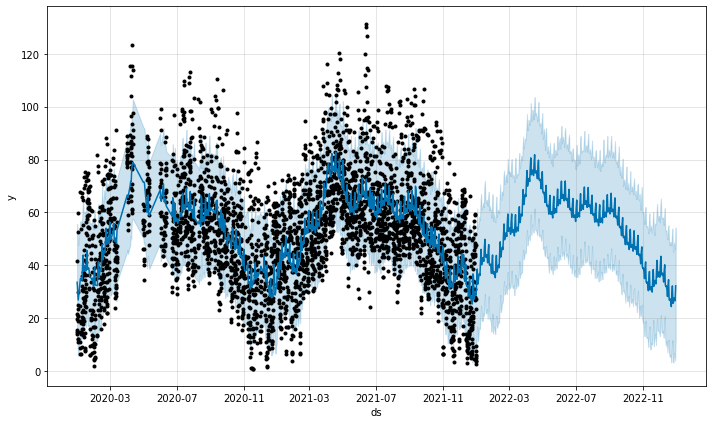

In [ ]:
fig1 = m.plot(forecast)


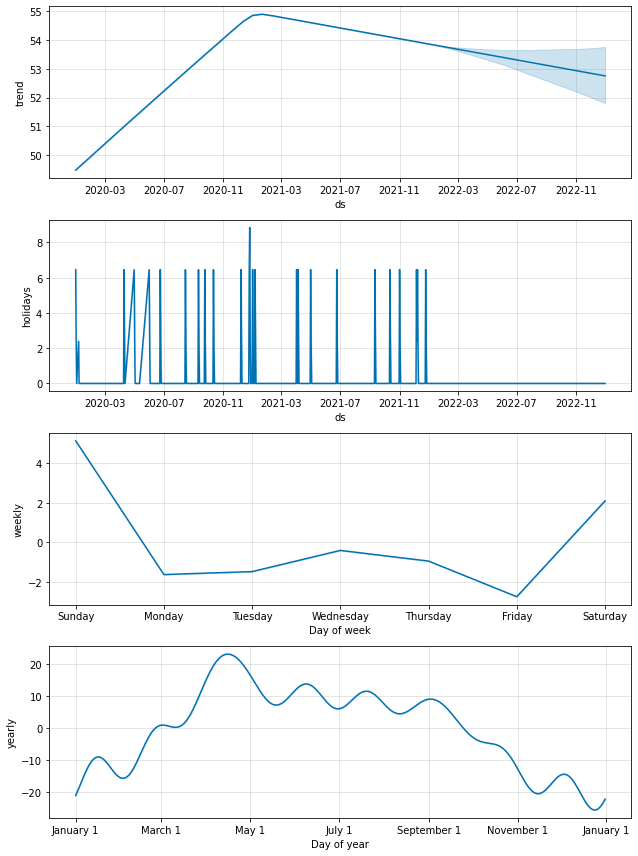

In [ ]:
fig2 = m.plot_components(forecast)

In [ ]:
from prophet.plot import plot_plotly, plot_components_plotly
plot_plotly(m, forecast)